# Visualize activations of the CNN

This notebook visualizes the activations of the convolutional layers of the CNN model trained on MNIST database. The model was trained and evaluated in the notebook titled: MNIST digit recognition CNN.ipynb  

this code is based on Gabriel Pierobon's tutorial: https://github.com/gabrielpierobon/cnnshapes

### Import modules

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


# Import and process image dataset

In [2]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

In [3]:
X_train = train_data.drop('label', axis=1)/255
Y_train = train_data['label']
X_test = test_data/255

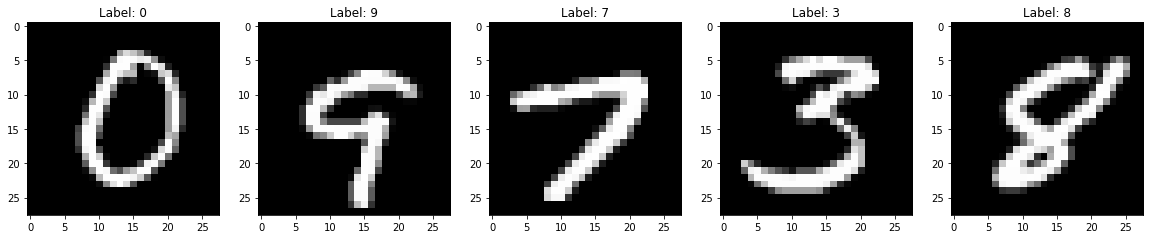

In [4]:
m_train = X_train.shape[0]
m_test = X_test.shape[0]
X_train_img = np.array(X_train).reshape((m_train,28,28,1))
X_test_img = np.array(X_test).reshape((m_test,28,28,1))

# Visualize some random images from the training set
ind = np.random.randint(0, m_train-1, size=(5))
fig, axes = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    axes[i].imshow(X_train_img[ind[i],:,:,0], cmap='gray')
    axes[i].set_title("Label: {:d}" .format(Y_train[ind[i]]))

# Import trained CNN model
model defined and trained in notebook titled 'MNIST digit recognition CNN'

In [5]:
def CnnModel():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(32, activation='relu'))
    cnn_model.add(Dense(10, activation='softmax'))

    cnn_model.summary()
    return cnn_model

In [6]:
cnn_model_augm_loaded = CnnModel()
cnn_model_augm_loaded.load_weights("cnn_model_augm.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
__________

In [43]:
layer_outputs = [layer.output for layer in cnn_model_augm_loaded.layers] 
# Extracts the outputs layers of the model
activation_model = models.Model(inputs=cnn_model_augm_loaded.input, outputs=layer_outputs)
# Creates a model that will return these outputs, given the model input

In [44]:
layer_outputs

[<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 26, 26, 32) dtype=float32>,
 <tf.Tensor 'conv2d_2/Relu:0' shape=(?, 24, 24, 64) dtype=float32>,
 <tf.Tensor 'batch_normalization_1/cond/Merge:0' shape=(?, 24, 24, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>,
 <tf.Tensor 'conv2d_3/Relu:0' shape=(?, 10, 10, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 5, 5, 128) dtype=float32>,
 <tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'dense_1/Relu:0' shape=(?, 32) dtype=float32>,
 <tf.Tensor 'dense_2/Softmax:0' shape=(?, 10) dtype=float32>]

## Print a single image from the training set

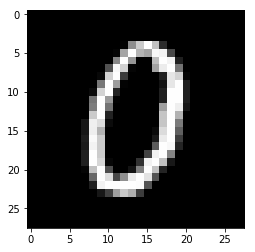

In [46]:
n_im = 5
plt.imshow(X_train_img[n_im,:,:,0], cmap='gray')
plt.show()

## Display the activation of a single channel in the first layer of the CNN

In [47]:
# Return a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(X_train_img[n_im:n_im+1,:,:,:6]) 

In [48]:
# Print the shape of the activations of the first layer: Conv2D 3x3, 32 channels -> 1x28x28x1 -> 1x26x26x32
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 26, 26, 32)


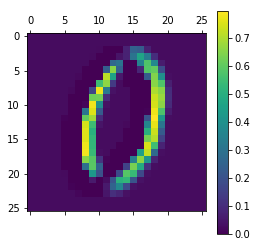

In [58]:
# Plot the activation of the fourth Channel in the first layer
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.colorbar()

In [78]:
def ShowAct(cnnmodel, img, n_convlayers=6):
    
    layer_outputs = [layer.output for layer in cnnmodel.layers[:n_convlayers]] 
    activation_model = models.Model(inputs=cnnmodel.input, outputs=layer_outputs)
    
    # Reshape image to 4-dimensional to match the imput shape of the CNN
    print(img.shape)
    if len(img.shape) == 2:
        img = img.reshape((1,28,28,1))     
    
    # Return the activations of each convolutional layer for a given image 
    activations = activation_model.predict(img) 
    
    layer_names = []
    for layer in cnnmodel.layers[:n_convlayers]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    print(layer_names)
    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of channels in the layer
        act_size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        print("Channels in layer: ", layer_name, ": ", str(n_features))
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        print("Display grid: ", str(act_size * n_cols), str(images_per_row * act_size))
        display_grid = np.zeros((act_size * n_cols, images_per_row * act_size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * act_size : (col + 1) * act_size, # Displays the grid
                             row * act_size : (row + 1) * act_size] = channel_image
        scale = 1. / act_size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

(28, 28)
['conv2d_1', 'conv2d_2', 'batch_normalization_1', 'max_pooling2d_1', 'conv2d_3', 'max_pooling2d_2']
Channels in layer:  conv2d_1 :  32
Display grid:  52 416
Channels in layer: 

C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


 conv2d_2 :  64
Display grid:  96 384
Channels in layer:  batch_normalization_1 :  64
Display grid:  96 384
Channels in layer:  max_pooling2d_1 :  64
Display grid:  48 192
Channels in layer:  conv2d_3 :  128
Display grid:  80 160
Channels in layer:  max_pooling2d_2 :  128
Display grid:  40 80


C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


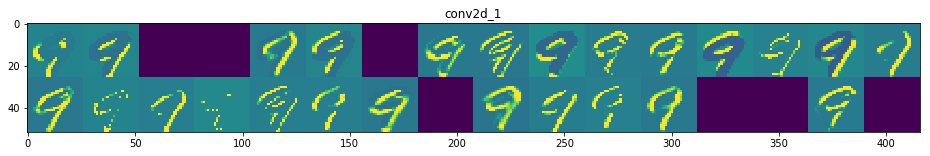

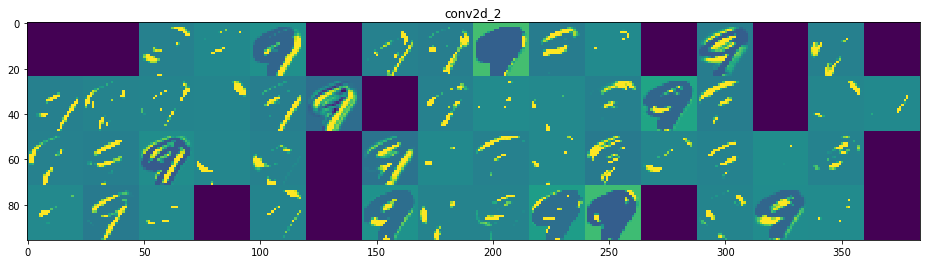

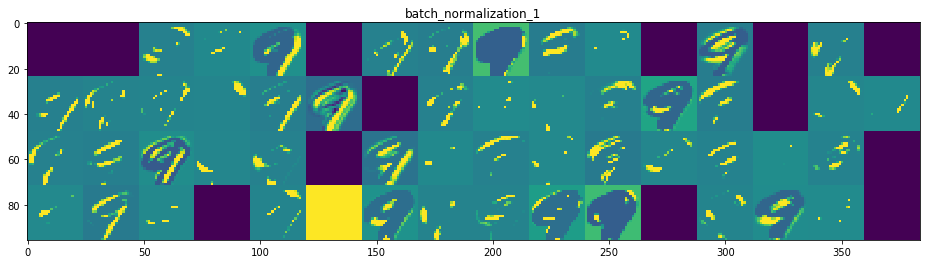

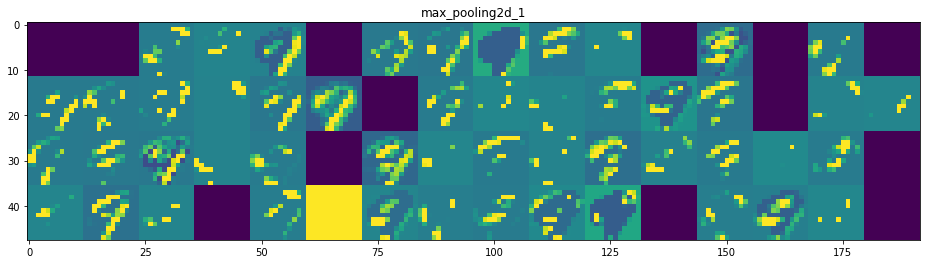

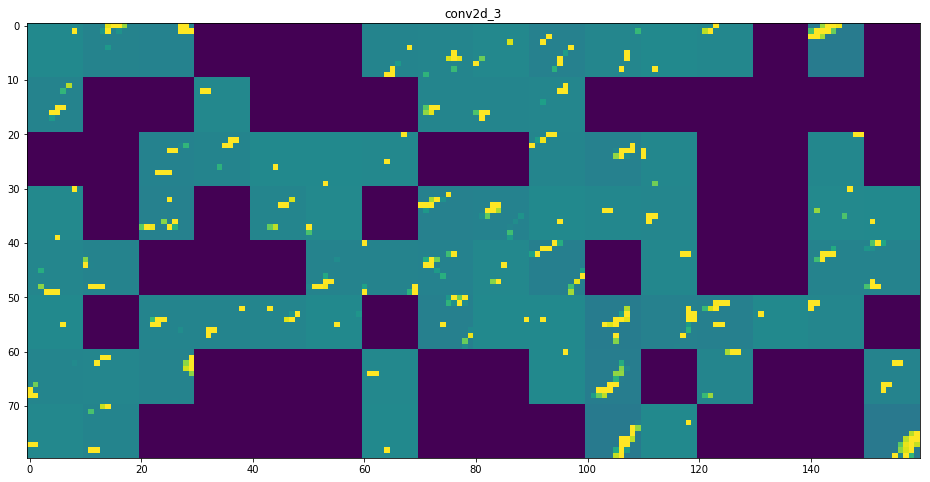

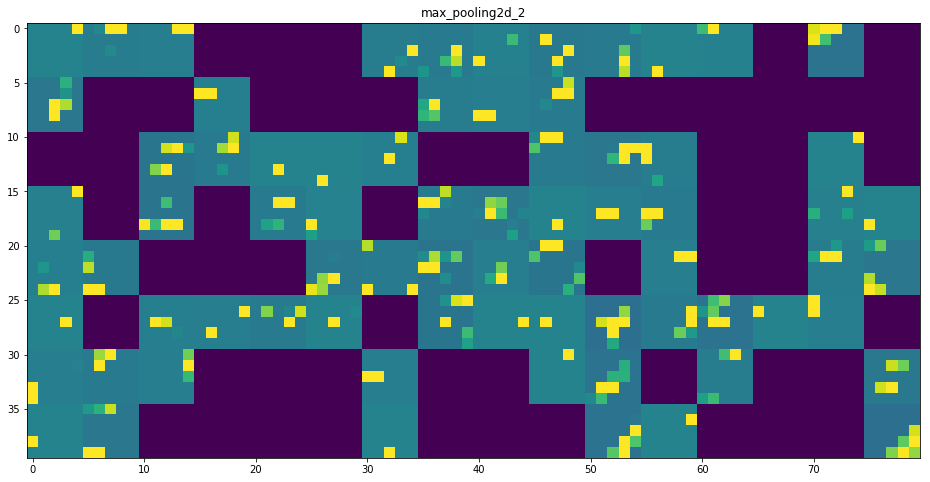

In [79]:
ShowAct(cnn_model_augm_loaded, np.array(X_train)[100].reshape((28,28)), n_convlayers=6)